# Exploration and Comparison of Transformers for Image Classification

## Linear Probing using Vision Transformer (ViT)

Linear Probing is an experiment that involes training a linear classifier on top of pre-trained frozen features of the model.

In this experiment, the whole training set is used.

### Vision Transformer (ViT)

Vision Transformer (ViT) model pre-trained on ImageNet-21k (14 million images, 21,843 classes) at resolution 224x224, and fine-tuned on ImageNet 2012 (1 million images, 1,000 classes) at resolution 224x224. It was introduced in the paper *An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale by Dosovitskiy et al.*

https://arxiv.org/abs/2010.11929

### Prerequisites

Load necessary packages.

In [75]:
import os
os.chdir('..')

import torch

import pandas as pd

from datasets import load_dataset

from src.dataset_builder import ImageDataset
from src.models import *
from src.train import *

from utils.config import Config
from utils.train_utils import *
from utils.models_utils import *
from utils.visualization_utils import *
from utils.data_utils import *

Check if there is GPU available.

In [3]:
get_gpu_info()

GPU 0: NVIDIA A100 80GB PCIe MIG 2g.20gb
VRAM: 19.50 GB


Set manual seed for reproducibility.

In [4]:
id = 10
torch.manual_seed(10)

Load ViT image processor used for image pre-processing.

In [5]:
processor = get_backbone_processor(model_names['ViT'])

Print the pre-processing operations done by the processor.

In [6]:
processor

ViTImageProcessorFast {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessorFast",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

### Data Preprocessing

Load each dataset and its splits.

Processor is automatically applied to each image.

#### RESISC45

In [8]:
resisc45 = load_dataset('timm/resisc45')
clean_labels(resisc45, name='resisc45')
resisc45_train = ImageDataset(
    dataset=resisc45['train'],
    processor=processor,
)
resisc45_validation = ImageDataset(
    dataset=resisc45['validation'],
    processor=processor,
)
resisc45_test = ImageDataset(
    dataset=resisc45['test'],
    processor=processor,
)

#### Food-101

In [10]:
food101 = load_dataset('ethz/food101')
clean_labels(food101, name='food101')
food101_train = ImageDataset(
    dataset=food101['train'],
    processor=processor,
)
food101_validation = ImageDataset(
    dataset=food101['validation'],
    processor=processor,
)

#### FER2013

In [12]:
fer2013 = load_dataset('AutumnQiu/fer2013')
clean_labels(fer2013, name='fer2013')
fer2013_train = ImageDataset(
    dataset=fer2013['train'],
    processor=processor,
)
fer2013_validation = ImageDataset(
    dataset=fer2013['valid'],
    processor=processor,
)
fer2013_test = ImageDataset(
    dataset=fer2013['test'],
    processor=processor,
)

#### PCam

In [14]:
pcam = load_dataset('zacharielegault/PatchCamelyon')
clean_labels(pcam, name='pcam')
pcam_train = ImageDataset(
    dataset=pcam['train'],
    processor=processor,
)
pcam_validation = ImageDataset(
    dataset=pcam['validation'],
    processor=processor,
)
pcam_test = ImageDataset(
    dataset=pcam['test'],
    processor=processor,
)

#### SUN397

In [16]:
sun397 = load_dataset('dpdl-benchmark/sun397')
clean_labels(sun397, name='sun397')
sun397_train = ImageDataset(
    dataset=sun397['train'],
    processor=processor,
)
sun397_validation = ImageDataset(
    dataset=sun397['validation'],
    processor=processor,
)
sun397_test = ImageDataset(
    dataset=sun397['test'],
    processor=processor,
)

Resolving data files:   0%|          | 0/28 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/28 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/28 [00:00<?, ?it/s]

#### DTD

In [17]:
dtd = load_dataset('tanganke/dtd')
clean_labels(dtd, name='dtd')
dtd_train = ImageDataset(
    dataset=dtd['train'],
    processor=processor,
)
dtd_test = ImageDataset(
    dataset=dtd['test'],
    processor=processor,
)

Casting the dataset:   0%|          | 0/3760 [00:00<?, ? examples/s]

Map:   0%|          | 0/3760 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1880 [00:00<?, ? examples/s]

Map:   0%|          | 0/1880 [00:00<?, ? examples/s]

### Config

Create a config for experiments and print its settings.

In [27]:
from torch.optim import AdamW

config = Config(
    num_epochs=10, 
    lr=1e-4,
    optimizer=AdamW
)
config.get_settings()

{'device': 'cuda',
 'criterion': CrossEntropyLoss(),
 'batch_size': 8,
 'lr': 0.0001,
 'num_epochs': 10,
 'optimizer': torch.optim.adamw.AdamW,
 'weight_decay': 0.0001}

Create empty array to store dataset accuracies for each experiment.

In [111]:
resisc45_accs = []
food101_accs = []
fer2013_accs = []
pcam_accs = []
sun397_accs = []
dtd_accs = []

### Linear Probing


Train a new linear classifier on top of pre-trained model base.

#### RESISC45

In [29]:
vit_resisc45 = Backbone(model_names['ViT'], num_classes=len(resisc45_train.get_labels()))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([45]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([45, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
get_model_params(vit_resisc45)

Parameters: 85.83M


In [31]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = train_model(
    vit_resisc45,
    resisc45_train,
    config,
    'vit',
    use_val=False,
    fine_tune=False,
)

100%|██████████| 2363/2363 [03:15<00:00, 12.10it/s]


Epochs: 1/10 | train_loss: 1.7766 | train_acc: 0.6074


100%|██████████| 2363/2363 [03:15<00:00, 12.10it/s]


Epochs: 2/10 | train_loss: 0.8883 | train_acc: 0.7800


100%|██████████| 2363/2363 [03:15<00:00, 12.06it/s]


Epochs: 3/10 | train_loss: 0.6968 | train_acc: 0.8181


100%|██████████| 2363/2363 [03:15<00:00, 12.09it/s]


Epochs: 4/10 | train_loss: 0.5945 | train_acc: 0.8412


100%|██████████| 2363/2363 [03:15<00:00, 12.09it/s]


Epochs: 5/10 | train_loss: 0.5265 | train_acc: 0.8574


100%|██████████| 2363/2363 [03:15<00:00, 12.08it/s]


Epochs: 6/10 | train_loss: 0.4774 | train_acc: 0.8719


100%|██████████| 2363/2363 [03:14<00:00, 12.12it/s]


Epochs: 7/10 | train_loss: 0.4386 | train_acc: 0.8812


100%|██████████| 2363/2363 [03:15<00:00, 12.10it/s]


Epochs: 8/10 | train_loss: 0.4068 | train_acc: 0.8897


100%|██████████| 2363/2363 [03:14<00:00, 12.13it/s]


Epochs: 9/10 | train_loss: 0.3804 | train_acc: 0.8980


100%|██████████| 2363/2363 [03:15<00:00, 12.06it/s]

Epochs: 10/10 | train_loss: 0.3577 | train_acc: 0.9047


In [32]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = evaluate_model(
    vit_resisc45,
    resisc45_test,
    config
)

100%|██████████| 788/788 [01:04<00:00, 12.19it/s]

test_loss: 0.5046 | test_acc: 0.8463


In [112]:
resisc45_accs.append(resisc45_acc)

In [34]:
get_top_5_accuracies(resisc45_per_class_acc)

[('sea ice', 0.9933774834437086),
 ('chaparral', 0.9848484848484849),
 ('mountain', 0.9739130434782609),
 ('snowberg', 0.9559748427672956),
 ('beach', 0.9538461538461539)]

In [35]:
get_bottom_5_accuracies(resisc45_per_class_acc)

[('palace', 0.55),
 ('tennis court', 0.5625),
 ('railway station', 0.7077922077922078),
 ('industrial area', 0.7285714285714285),
 ('basketball court', 0.753731343283582)]

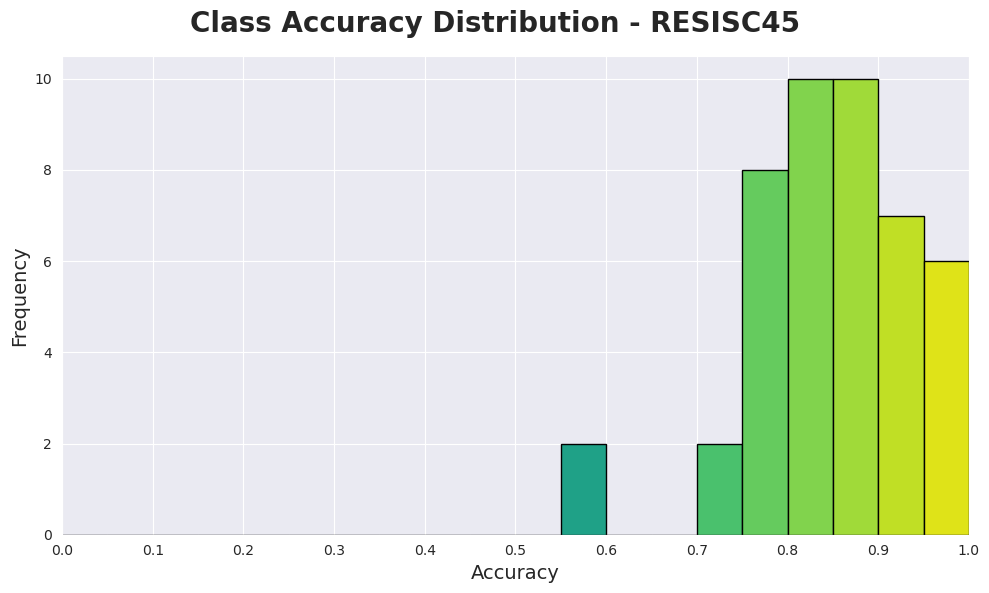

In [36]:
plot_per_class_accuracies(
    resisc45_per_class_acc,
    'RESISC45',
    num_bins=20
)

#### Food-101

In [37]:
vit_food101 = Backbone(model_names['ViT'], num_classes=len(food101_train.get_labels()))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([101]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([101, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
get_model_params(vit_food101)

Parameters: 85.88M


In [39]:
food101_loss, food101_acc, food101_per_class_acc = train_model(
    vit_food101,
    food101_train,
    config,
    'vit',
    use_val=False,
    fine_tune=False,
)

 33%|███▎      | 3140/9469 [05:01<09:57, 10.59it/s]/opt/conda/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:868: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████| 9469/9469 [15:03<00:00, 10.48it/s]


Epochs: 1/10 | train_loss: 1.2381 | train_acc: 0.7256


100%|██████████| 9469/9469 [14:51<00:00, 10.62it/s]


Epochs: 2/10 | train_loss: 0.7413 | train_acc: 0.8039


100%|██████████| 9469/9469 [14:52<00:00, 10.61it/s]


Epochs: 3/10 | train_loss: 0.6634 | train_acc: 0.8228


100%|██████████| 9469/9469 [14:54<00:00, 10.58it/s]


Epochs: 4/10 | train_loss: 0.6155 | train_acc: 0.8350


100%|██████████| 9469/9469 [14:53<00:00, 10.60it/s]


Epochs: 5/10 | train_loss: 0.5802 | train_acc: 0.8448


100%|██████████| 9469/9469 [14:50<00:00, 10.63it/s]


Epochs: 6/10 | train_loss: 0.5530 | train_acc: 0.8519


100%|██████████| 9469/9469 [14:51<00:00, 10.62it/s]


Epochs: 7/10 | train_loss: 0.5292 | train_acc: 0.8585


100%|██████████| 9469/9469 [14:50<00:00, 10.64it/s]


Epochs: 8/10 | train_loss: 0.5100 | train_acc: 0.8634


100%|██████████| 9469/9469 [14:50<00:00, 10.63it/s]


Epochs: 9/10 | train_loss: 0.4932 | train_acc: 0.8688


100%|██████████| 9469/9469 [14:51<00:00, 10.63it/s]


Epochs: 10/10 | train_loss: 0.4780 | train_acc: 0.8721


In [40]:
food101_loss, food101_acc, food101_per_class_acc = evaluate_model(
    vit_food101,
    food101_validation,
    config
)

100%|██████████| 3157/3157 [04:54<00:00, 10.71it/s]

test_loss: 0.4950 | test_acc: 0.8596


In [113]:
food101_accs.append(food101_acc)

In [42]:
get_top_5_accuracies(food101_per_class_acc)

[('edamame', 0.992),
 ('oysters', 0.972),
 ('pho', 0.972),
 ('pizza', 0.972),
 ('macarons', 0.968)]

In [43]:
get_bottom_5_accuracies(food101_per_class_acc)

[('pork chop', 0.556),
 ('steak', 0.568),
 ('chocolate cake', 0.66),
 ('ceviche', 0.668),
 ('scallops', 0.672)]

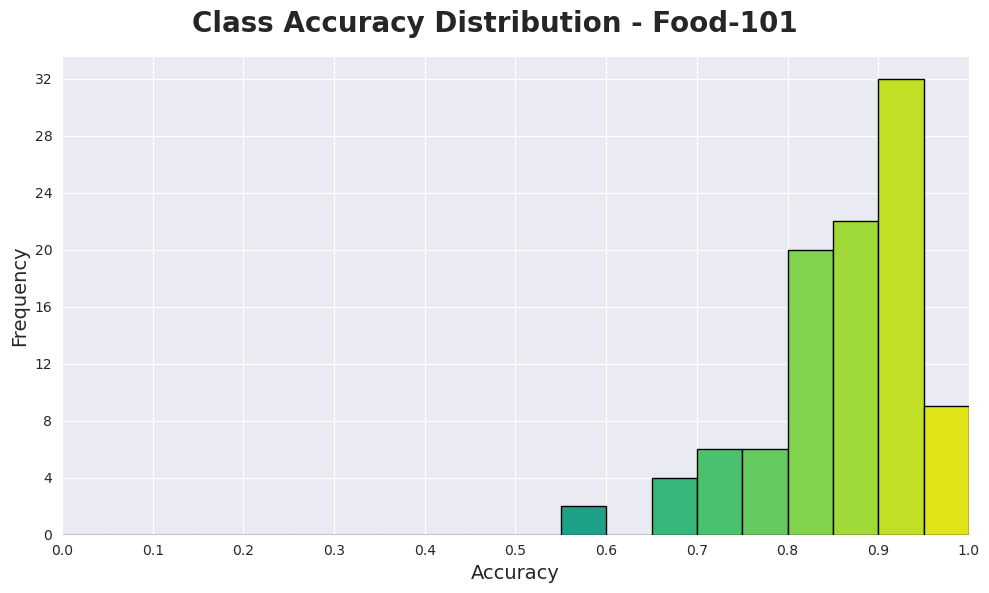

In [44]:
plot_per_class_accuracies(
    food101_per_class_acc,
    'Food-101',
    num_bins=20
)

#### FER2013

In [76]:
vit_fer2013 = Backbone(model_names['ViT'], num_classes=len(fer2013_train.get_labels()))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [77]:
get_model_params(vit_fer2013)

Parameters: 85.80M


In [78]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = train_model(
    vit_fer2013,
    fer2013_train,
    config,
    'vit',,
    use_val=False,
    fine_tune=False,
)

100%|██████████| 3589/3589 [04:38<00:00, 12.89it/s]


Epochs: 1/10 | train_loss: 1.3044 | train_acc: 0.5120


100%|██████████| 3589/3589 [04:39<00:00, 12.86it/s]


Epochs: 2/10 | train_loss: 1.1471 | train_acc: 0.5732


100%|██████████| 3589/3589 [04:38<00:00, 12.90it/s]


Epochs: 3/10 | train_loss: 1.1046 | train_acc: 0.5870


100%|██████████| 3589/3589 [04:37<00:00, 12.91it/s]


Epochs: 4/10 | train_loss: 1.0811 | train_acc: 0.5982


100%|██████████| 3589/3589 [04:37<00:00, 12.91it/s]


Epochs: 5/10 | train_loss: 1.0640 | train_acc: 0.6040


100%|██████████| 3589/3589 [04:38<00:00, 12.88it/s]


Epochs: 6/10 | train_loss: 1.0509 | train_acc: 0.6111


100%|██████████| 3589/3589 [04:38<00:00, 12.90it/s]


Epochs: 7/10 | train_loss: 1.0411 | train_acc: 0.6147


100%|██████████| 3589/3589 [04:37<00:00, 12.92it/s]


Epochs: 8/10 | train_loss: 1.0323 | train_acc: 0.6168


100%|██████████| 3589/3589 [04:38<00:00, 12.91it/s]


Epochs: 9/10 | train_loss: 1.0250 | train_acc: 0.6202


100%|██████████| 3589/3589 [04:37<00:00, 12.92it/s]

Epochs: 10/10 | train_loss: 1.0189 | train_acc: 0.6213


In [79]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = evaluate_model(
    vit_fer2013,
    fer2013_test,
    config
)

100%|██████████| 449/449 [00:34<00:00, 12.93it/s]

test_loss: 1.0559 | test_acc: 0.6018


In [114]:
fer2013_accs.append(fer2013_acc)

In [81]:
fer2013_per_class_acc

{'angry': 0.46435845213849286,
 'disgust': 0.3090909090909091,
 'fear': 0.3352272727272727,
 'happy': 0.888509670079636,
 'sad': 0.5336700336700336,
 'surprise': 0.6610576923076923,
 'neutral': 0.5830670926517572}

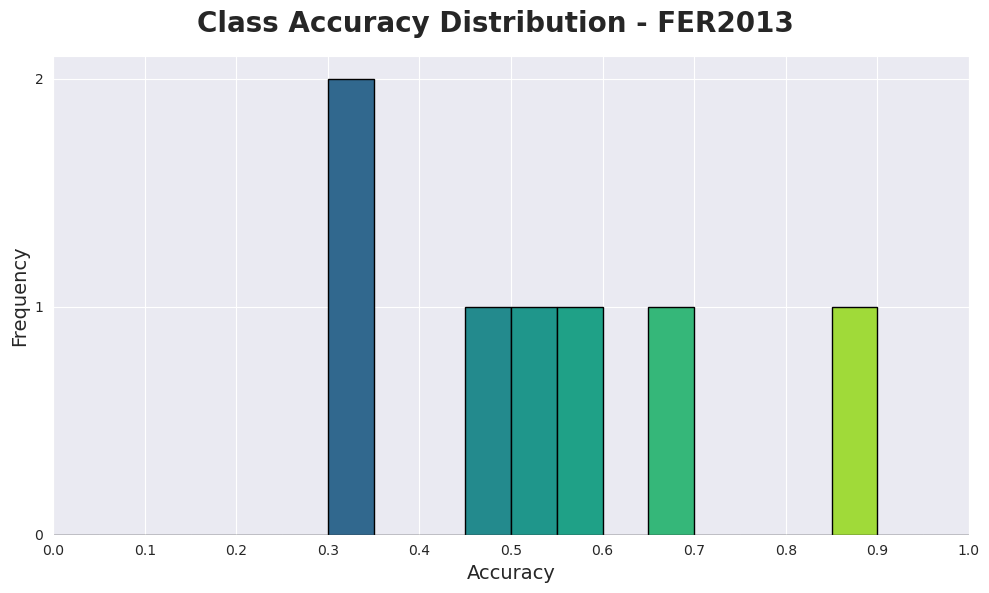

In [82]:
plot_per_class_accuracies(
    fer2013_per_class_acc,
    'FER2013',
    num_bins=20
)

#### PCam

In [83]:
vit_pcam = Backbone(model_names['ViT'], num_classes=len(pcam_train.get_labels()))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [84]:
get_model_params(vit_pcam)

Parameters: 85.80M


In [85]:
pcam_loss, pcam_acc, pcam_per_class_acc = train_model(
    vit_pcam,
    pcam_train,
    config,
    'vit',
    use_val=False,
    fine_tune=False,
)

100%|██████████| 32768/32768 [42:55<00:00, 12.72it/s]


Epochs: 1/10 | train_loss: 0.3051 | train_acc: 0.8707


100%|██████████| 32768/32768 [42:53<00:00, 12.73it/s]


Epochs: 2/10 | train_loss: 0.2638 | train_acc: 0.8927


100%|██████████| 32768/32768 [42:55<00:00, 12.73it/s]


Epochs: 3/10 | train_loss: 0.2534 | train_acc: 0.8978


100%|██████████| 32768/32768 [42:54<00:00, 12.73it/s]


Epochs: 4/10 | train_loss: 0.2484 | train_acc: 0.9002


100%|██████████| 32768/32768 [42:55<00:00, 12.72it/s]


Epochs: 5/10 | train_loss: 0.2448 | train_acc: 0.9021


100%|██████████| 32768/32768 [42:54<00:00, 12.73it/s]


Epochs: 6/10 | train_loss: 0.2424 | train_acc: 0.9032


100%|██████████| 32768/32768 [42:54<00:00, 12.73it/s]


Epochs: 7/10 | train_loss: 0.2408 | train_acc: 0.9042


100%|██████████| 32768/32768 [42:56<00:00, 12.72it/s]


Epochs: 8/10 | train_loss: 0.2393 | train_acc: 0.9046


100%|██████████| 32768/32768 [42:54<00:00, 12.73it/s]


Epochs: 9/10 | train_loss: 0.2381 | train_acc: 0.9052


100%|██████████| 32768/32768 [42:55<00:00, 12.72it/s]


Epochs: 10/10 | train_loss: 0.2374 | train_acc: 0.9058


In [86]:
pcam_loss, pcam_acc, pcam_per_class_acc = evaluate_model(
    vit_pcam,
    pcam_test,
    config
)

100%|██████████| 4096/4096 [05:20<00:00, 12.77it/s]

test_loss: 0.3589 | test_acc: 0.8431


In [115]:
pcam_accs.append(pcam_acc)

In [88]:
pcam_per_class_acc

{'healthy lymph node tissue': 0.9237386370569215,
 'lymph node tumor tissue': 0.7623496366855956}

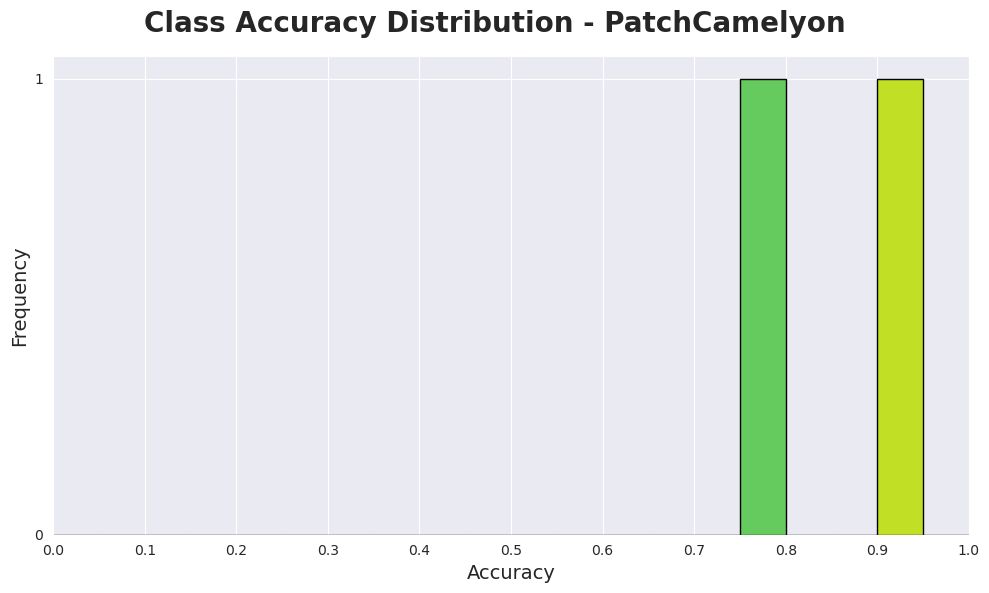

In [89]:
plot_per_class_accuracies(
    pcam_per_class_acc,
    'PatchCamelyon',
    num_bins=20
)

#### SUN397

In [90]:
vit_sun397 = Backbone(model_names['ViT'], num_classes=len(sun397_train.get_labels()))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([397]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([397, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [91]:
get_model_params(vit_sun397)

Parameters: 86.10M


In [92]:
sun397_loss, sun397_acc, sun397_per_class_acc = train_model(
    vit_sun397,
    sun397_train,
    config,
    'vit',
    use_val=False,
    fine_tune=False,
)

100%|██████████| 9516/9516 [16:02<00:00,  9.88it/s]


Epochs: 1/10 | train_loss: 1.5558 | train_acc: 0.6716


100%|██████████| 9516/9516 [15:58<00:00,  9.93it/s]


Epochs: 2/10 | train_loss: 0.7461 | train_acc: 0.7884


100%|██████████| 9516/9516 [16:00<00:00,  9.91it/s]


Epochs: 3/10 | train_loss: 0.6337 | train_acc: 0.8156


100%|██████████| 9516/9516 [16:00<00:00,  9.91it/s]


Epochs: 4/10 | train_loss: 0.5615 | train_acc: 0.8356


100%|██████████| 9516/9516 [16:00<00:00,  9.90it/s]


Epochs: 5/10 | train_loss: 0.5077 | train_acc: 0.8517


100%|██████████| 9516/9516 [15:59<00:00,  9.92it/s]


Epochs: 6/10 | train_loss: 0.4630 | train_acc: 0.8652


100%|██████████| 9516/9516 [16:01<00:00,  9.90it/s]


Epochs: 7/10 | train_loss: 0.4270 | train_acc: 0.8765


100%|██████████| 9516/9516 [16:00<00:00,  9.91it/s]


Epochs: 8/10 | train_loss: 0.3957 | train_acc: 0.8875


100%|██████████| 9516/9516 [15:59<00:00,  9.91it/s]


Epochs: 9/10 | train_loss: 0.3694 | train_acc: 0.8956


100%|██████████| 9516/9516 [16:00<00:00,  9.91it/s]


Epochs: 10/10 | train_loss: 0.3466 | train_acc: 0.9031


In [93]:
sun397_loss, sun397_acc, sun397_per_class_acc = evaluate_model(
    vit_sun397,
    sun397_test,
    config
)

100%|██████████| 2719/2719 [04:35<00:00,  9.85it/s]


test_loss: 0.7897 | test_acc: 0.7745


In [116]:
sun397_accs.append(sun397_acc)

In [95]:
get_top_5_accuracies(sun397_per_class_acc)

[('batters box', 1.0),
 ('bullring', 1.0),
 ('oast house', 1.0),
 ('raceway', 1.0),
 ('raft', 1.0)]

In [96]:
get_bottom_5_accuracies(sun397_per_class_acc)

[('bistro (indoor)', 0.0),
 ('recreation room', 0.037037037037037035),
 ('coffee shop', 0.14814814814814814),
 ('courtyard', 0.16666666666666666),
 ('inn (outdoor)', 0.1724137931034483)]

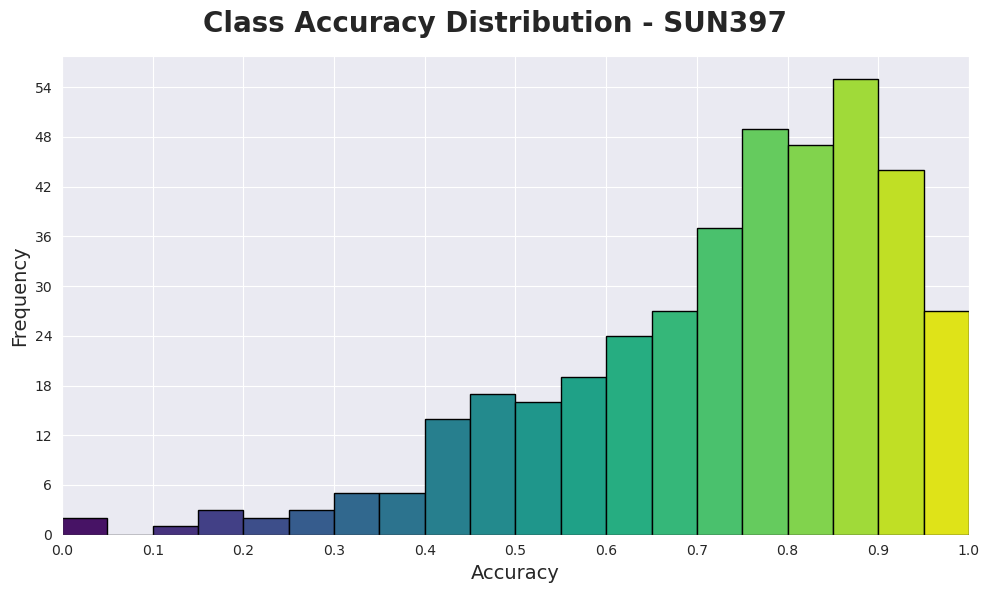

In [97]:
plot_per_class_accuracies(
    sun397_per_class_acc,
    'SUN397',
    num_bins=20
)

#### DTD

In [98]:
vit_dtd = Backbone(model_names['ViT'], num_classes=len(dtd_train.get_labels()))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([47]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([47, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [99]:
get_model_params(vit_dtd)

Parameters: 85.83M


In [100]:
dtd_loss, dtd_acc, dtd_per_class_acc = train_model(
    vit_dtd,
    dtd_train,
    config,
    'vit',
    use_val=False,
    fine_tune=False,
)

100%|██████████| 470/470 [00:46<00:00, 10.15it/s]


Epochs: 1/10 | train_loss: 3.1578 | train_acc: 0.3019


100%|██████████| 470/470 [00:46<00:00, 10.17it/s]


Epochs: 2/10 | train_loss: 2.0016 | train_acc: 0.6237


100%|██████████| 470/470 [00:46<00:00, 10.21it/s]


Epochs: 3/10 | train_loss: 1.4767 | train_acc: 0.7048


100%|██████████| 470/470 [00:45<00:00, 10.26it/s]


Epochs: 4/10 | train_loss: 1.1999 | train_acc: 0.7481


100%|██████████| 470/470 [00:45<00:00, 10.24it/s]


Epochs: 5/10 | train_loss: 1.0243 | train_acc: 0.7763


100%|██████████| 470/470 [00:45<00:00, 10.29it/s]


Epochs: 6/10 | train_loss: 0.8988 | train_acc: 0.7981


100%|██████████| 470/470 [00:46<00:00, 10.21it/s]


Epochs: 7/10 | train_loss: 0.8008 | train_acc: 0.8218


100%|██████████| 470/470 [00:46<00:00, 10.21it/s]


Epochs: 8/10 | train_loss: 0.7209 | train_acc: 0.8420


100%|██████████| 470/470 [00:45<00:00, 10.23it/s]


Epochs: 9/10 | train_loss: 0.6539 | train_acc: 0.8548


100%|██████████| 470/470 [00:45<00:00, 10.28it/s]

Epochs: 10/10 | train_loss: 0.5963 | train_acc: 0.8734


In [101]:
dtd_loss, dtd_acc, dtd_per_class_acc = evaluate_model(
    vit_dtd,
    dtd_test,
    config
)

100%|██████████| 235/235 [00:22<00:00, 10.34it/s]

test_loss: 0.9745 | test_acc: 0.7303


In [117]:
dtd_accs.append(dtd_acc)

In [103]:
get_top_5_accuracies(dtd_per_class_acc)

[('crystalline', 0.95),
 ('frilly', 0.95),
 ('knitted', 0.95),
 ('cobwebbed', 0.925),
 ('stratified', 0.925)]

In [104]:
get_bottom_5_accuracies(dtd_per_class_acc)

[('blotchy', 0.4),
 ('stained', 0.45),
 ('grid', 0.475),
 ('pitted', 0.475),
 ('woven', 0.475)]

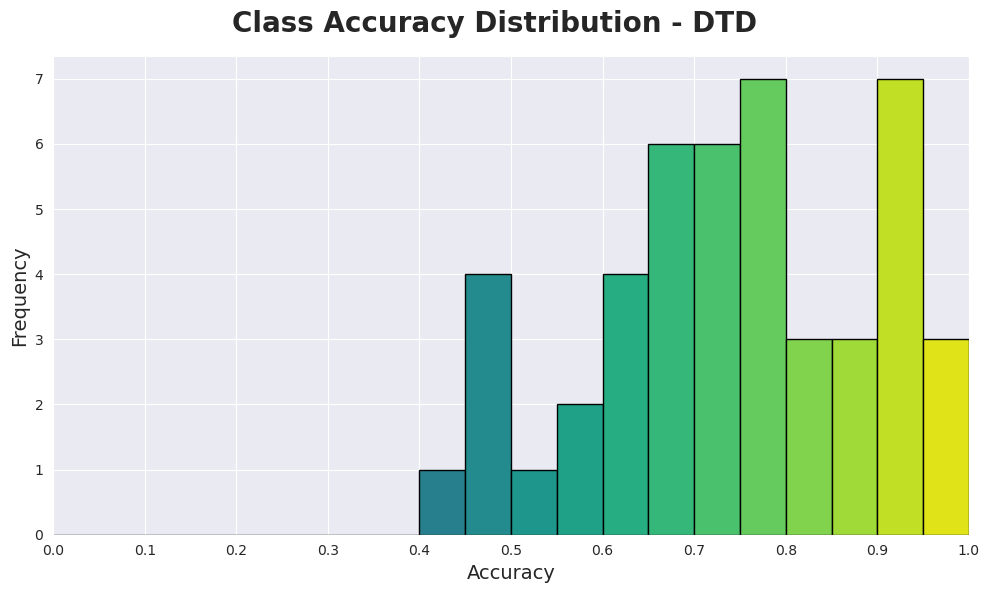

In [105]:
plot_per_class_accuracies(
    dtd_per_class_acc,
    'DTD',
    num_bins=20
)

### Results

Display the results of the analysis in dataframe.

In [118]:
results = [
    resisc45_accs,
    food101_accs,
    fer2013_accs,
    pcam_accs,
    sun397_accs,
    dtd_accs,
]

In [119]:
labels = ['RESISC45', 'Food-101', 'FER2013', 'PatchCamelyon', 'SUN397', 'DTD']

In [120]:
acc_dict = create_accuracy_dict(
    results,
    labels
)

In [125]:
df = pd.DataFrame(results, columns=['linear probe'], index=labels)
df

,linear probe
RESISC45,0.846349
Food-101,0.859644
FER2013,0.601839
PatchCamelyon,0.843079
SUN397,0.774529
DTD,0.730319
